In [1]:
import numpy as np
import pandas as pd

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# фиксирую RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# зафиксирую версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [6]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


### Работа с пропущенными данными

In [7]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [8]:
# Замена пропусков
feat_1_mode = hotels['lat'].mode()                  # расчёт моды географической широты отеля
feat_2_mode = hotels['lng'].mode()                  # расчёт моды географической долготы отеля

hotels['lat'].fillna(feat_1_mode[0], inplace=True)  # замена пропусков на моду географической широты отеля
hotels['lng'].fillna(feat_2_mode[0], inplace=True)  # замена пропусков на моду географической долготы отеля

In [9]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Создание новых признаков

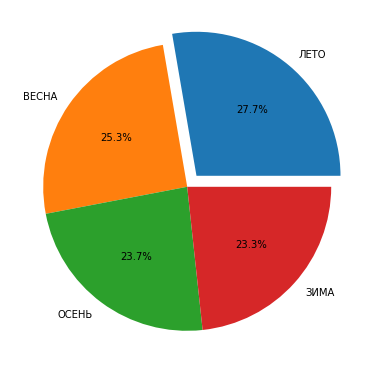

In [10]:
# Попробуем извлечь несколько признаков из даты, работа с колонкой 'review_date'
# преобразовываем колонку даты в формат datetime
hotels_review_date = pd.to_datetime(hotels['review_date'])

# извлекаем день недели из даты
hotels_day_of_week = hotels_review_date.dt.dayofweek

# извлекаем месяц из даты
hotels_month = hotels_review_date.dt.month

# создаём и используем функцию для извлечения сезона
def get_season(date):
    if date.month in [1, 2, 12]:
        return 'ЗИМА'
    if date.month in [3, 4, 5]:
        return 'ВЕСНА'
    if date.month in [6, 7, 8]:
        return 'ЛЕТО'
    else:
        return 'ОСЕНЬ'
hotels_season = hotels_review_date.apply(get_season)

# визуализируем распределение данных по сезонам
season_data = hotels_season.value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    season_data,
    labels = season_data.index,
    autopct = '%.1f%%',
    explode = [0.1, 0, 0, 0]
);

In [11]:
# проанализируем датасет на возможность добавления внешних источников данных, работа с колонкой 'hotel_address'
list(hotels['hotel_address'].unique())[:10] # посмотрим, какую информацию содержит в себе колонка 'hotel_address'

['Via Senigallia 6 20161 Milan Italy',
 'Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands',
 'Mallorca 251 Eixample 08008 Barcelona Spain',
 'Piazza Della Repubblica 17 Central Station 20124 Milan Italy',
 'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands',
 'Coram Street Camden London WC1N 1HT United Kingdom',
 'Empire Way Wembley Brent London HA9 8DS United Kingdom',
 '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom',
 '35 Rue Caumartin 9th arr 75009 Paris France',
 '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom']

In [12]:
# создаём функцию для извлечения города из адреса
def get_city(address):
    address_list = address.split(' ')
    if address_list[-2] == 'United' and address_list[-1] == 'Kingdom':
        return address_list[-5]
    else:
        return address_list[-2]

# создаём функцию для извлечения страны из адреса
def get_country(address):
    address_list = address.split(' ')
    if address_list[-2] == 'United' and address_list[-1] == 'Kingdom':
        return address_list[-2] + ' ' + address_list[-1]
    else:
        return address_list[-1]

# создаём колонки с названиями городов и стран
hotels['city'] = hotels['hotel_address'].apply(get_city)
hotels['country'] = hotels['hotel_address'].apply(get_country)

# проверяем полученные данные
print('Города:', hotels['city'].unique())
print('Страны:', hotels['country'].unique())

Города: ['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']
Страны: ['Italy' 'Netherlands' 'Spain' 'United Kingdom' 'France' 'Austria']


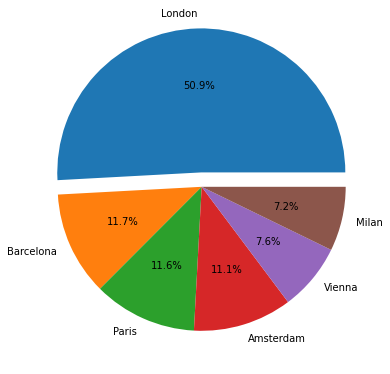

In [13]:
# извлекаем из Википедии информацию о населении и площади имеющихся у нас городов и стран
city_data = pd.DataFrame({
    'city': ['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
    'city_population': [1378689, 872757, 1636732, 8961989, 2148327, 1897491],
    'city_area': [181.67, 219.4, 101.3, 1602, 105.4, 414.75]
})
country_data = pd.DataFrame({
    'country': ['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria'],
    'country_population': [59236213, 17665300, 46552504, 67081000, 68084217, 8923507],
    'country_area': [302073, 41543, 505990, 242495, 643801, 83879]
})

# добавим колонки с плотностью населения
city_data['city_density'] = (city_data['city_population'] / city_data['city_area']).astype('int')
country_data['country_density'] = (country_data['country_population'] / country_data['country_area']).astype('int')

# добавляем полученные данные к датасету с отелями
hotels = hotels.join(city_data.set_index('city'), on = 'city')
hotels = hotels.join(country_data.set_index('country'), on = 'country')

# создадим дополнительную колонку-индикатор, находится ли отель в столице
capitals = ['Amsterdam', 'London', 'Paris', 'Vienna']
hotels['is_capital'] = hotels['city'].apply(lambda x: 1 if x in capitals else 0)

# визуализируем распределение данных по городам
city_data = hotels['city'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    city_data,
    labels = city_data.index,
    autopct = '%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0]
);

In [14]:
# выясним сколько отелей представлено в наборе данных
hotel_name2 = list(dict.fromkeys(hotels['hotel_name'])) # убрали дубликаты отелей
print(len(hotel_name2)) # узнали количество отелей в списке

1492


In [15]:
# Ответим на вопросы о дате размещения отзывов
# Когда был оставлен самый свежий отзыв? Введем ответ в формате yyyy-mm-dd.
print(max(hotels['review_date']))

# Когда был оставлен самый первый отзыв? Введем ответ в формате yyyy-mm-dd.
print(min(hotels['review_date']))

9/9/2016
1/1/2016


In [16]:
# Сколько уникальных тегов представлено в наборе данных
import re
def re_func(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found
print(hotels['tags'].apply(re_func).explode().nunique())

2428


In [17]:
# Выясним какой тег представлен в наибольшем числе отзывов

tags = [] # создаём полный список тэгов
for tag_list in hotels['tags'].values:
    tag_list = tag_list.replace("[' ", "")
    tag_list = tag_list.replace(" ']", "")
    tag_list = tag_list.split(" ', ' ")
    tags.extend(tag_list)

from collections import Counter
    
# подсчитываем количество тэгов с помощью класса Counter
tag_counter = Counter(tags)
sorted_tags = list(tag_counter.most_common())
sorted_tags[:1]

[('Leisure trip', 417778)]

In [18]:
# Из тегов выясним, на сколько ночей чаще всего останавливаются путешественники в отелях
import numpy as np

def get_stayed_nights(tags):
    tags_list = tags.split(' ')
    if 'Stayed' in tags_list:
        night_index = tags_list.index('Stayed') + 1
        return int(tags_list[night_index])
    else:
        return np.NaN

hotels['stayed_nights'] = hotels['tags'].apply(get_stayed_nights)

import statistics as st

st.mode(hotels['stayed_nights']) # чаще всего на 1 ночь

1.0

## Первоначальный вывод
### За период с 2015-08-04 по 2017-08-03 было размещено 2428 уникальных тега, которые рецензент дал 1492 отелям.Все отели находятся в 6 крупных городах разных стран. Большая часть которых 50.9% находятся в Лондоне столице Великобритании. Основная рецензия отелей это "Туристические поездки", поэтому чаще всего путешественники останавливаются на 1 ночь в отелях

In [19]:
# заполним пропуски в географических координатах модальным значением в зависимости от города
hotels['lat'] = hotels['lat'].fillna(
    hotels.groupby(['city'])['lat'].transform(lambda x: x.mode()[0])
)
hotels['lng'] = hotels['lng'].fillna(
    hotels.groupby(['city'])['lng'].transform(lambda x: x.mode()[0])
)

# пропущенные значения в колонке 'stayed_nights' заполняем модальным значением
hotels['stayed_nights'].fillna(hotels['stayed_nights'].mode()[0], inplace=True)
# и заменяем тип данных на 'int'
hotels['stayed_nights'] = hotels['stayed_nights'].astype('int')
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [20]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

### так как у нас признаки номинальные и признаков больше 15 используем двоичное кодирование.Учитывая что у нас много категорий в этом случая выполним маштабирование

In [21]:
# сохраняем колонки которые будем преобразовывать
X_hotels = []
for col in hotels.columns:
    if (hotels[col].min() < 0 or hotels[col].max() > 1) and col != 'reviewer_score':
        X_hotels.append(col)

from sklearn import preprocessing

# Создание экземпляра класса MinMaxScaler(), диапазон {0,1}
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# Масштабирование признака
X_hotels_scaled = minmax_scaler.fit_transform(hotels[X_hotels])

# Данные до и после масштабирования
print('До масштабирования:   ', X_hotels[:5])
print('После масштабирования:',  X_hotels_scaled[:5])

До масштабирования:    ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts']
После масштабирования: [[0.33681462 0.63043478 0.12745098 1.         0.15696203 0.
  0.37977197 0.56794244 0.06254389 0.05355501 0.22011582 0.85044121
  0.43258869 0.31231231 0.03333333]
 [0.22790004 0.73913043 0.0245098  0.29921212 0.         0.01694915
  0.99868749 0.30979248 0.         0.07869661 0.         0.14776349
  0.         1.         0.        ]
 [0.01678478 0.67391304 0.00735294 0.01852409 0.01265823 0.03954802
  0.00585415 0.15068037 0.09444345 0.         0.74245657 0.63604708
  0.77117614 0.         0.        ]
 [0.08951884 0.84782609 0.         0.09021471 0.06835443 0.02259887
  0.37496253 0.56944231 0.06254389 0.05355501 0.22011582 0.85044121
  0.43258869 0.31231231 0.        ]
 [0.31070496 0.84782609 0.         0.27930475 0.01772152 0.00282486
  0.99732324 0.31301892 0.         0.07869661 0.       

In [22]:
# преобразуем промежуточный датасет в полноценный датафрейм
X_hotels_scaled = pd.DataFrame(X_hotels_scaled, columns = X_hotels)

# удаляем преобразованные колонки из исходного датасета
hotels = hotels.drop(X_hotels, axis = 1)

# объеденяем данные
hotels = pd.concat([X_hotels_scaled, hotels], axis = 1)
hotels

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,city_population,city_area,city_density,country_population,country_area,country_density,stayed_nights,sample,reviewer_score,is_capital
0,0.336815,0.630435,0.127451,1.000000,0.156962,0.000000,0.379772,0.567942,0.062544,0.053555,0.220116,0.850441,0.432589,0.312312,0.033333,0,0.0,0
1,0.227900,0.739130,0.024510,0.299212,0.000000,0.016949,0.998687,0.309792,0.000000,0.078697,0.000000,0.147763,0.000000,1.000000,0.000000,0,0.0,1
2,0.016785,0.673913,0.007353,0.018524,0.012658,0.039548,0.005854,0.150680,0.094443,0.000000,0.742457,0.636047,0.771176,0.000000,0.000000,0,0.0,0
3,0.089519,0.847826,0.000000,0.090215,0.068354,0.022599,0.374963,0.569442,0.062544,0.053555,0.220116,0.850441,0.432589,0.312312,0.000000,0,0.0,0
4,0.310705,0.847826,0.000000,0.279305,0.017722,0.002825,0.997323,0.313019,0.000000,0.078697,0.000000,0.147763,0.000000,1.000000,0.033333,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0.039537,0.826087,0.000000,0.034522,0.025316,0.025424,0.918157,0.010638,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.033333,1,8.8,1
515734,0.101082,0.695652,0.000000,0.191315,0.235443,0.000000,0.619953,0.998227,0.126679,0.208869,0.036452,0.000000,0.070295,0.042042,0.100000,1,9.2,1
515735,0.170086,0.347826,0.029412,0.162868,0.022785,0.056497,0.920574,0.014208,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,1,8.3,1
515736,0.135770,0.630435,0.000000,0.091658,0.015190,0.076271,0.920062,0.012482,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.033333,1,9.2,1


## Отбор признаков

<AxesSubplot:>

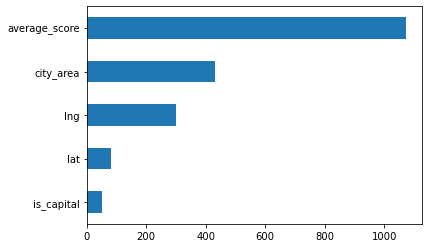

In [23]:
# Для начала разделим признаки по типу, перечислим их:
# непрерывные признаки
num_cols = [
    'total_number_of_reviews', 'review_total_negative_word_counts', 
    'review_total_positive_word_counts','additional_number_of_scoring',
    'total_number_of_reviews_reviewer_has_given', 'city_population',
    'country_population', 'city_density', 'stayed_nights',
    'country_density', 'country_area'
]


# категориальные признаки
cat_cols = ['average_score', 'lat', 'lng', 'city_area', 'is_capital']

# разбиваем датафрейм на части, необходимые для оценки значимости
# X - данные с информацией об отелях, y - целевая переменная (рейтинги отелей)

X = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score'].astype('int')

# библиотеки для оценки значимости
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

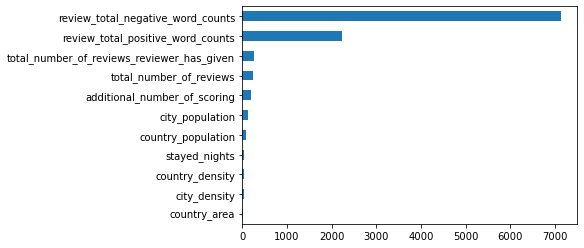

In [24]:
from sklearn.feature_selection import f_classif # anova
# оценка значимости непрерывных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## РАЗДЕЛЕНИЕ НАБОРА ДАННЫХ

In [25]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels.reviewer_score.values

In [26]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED) 

In [27]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 17), (386803, 17), (515738, 17), (386803, 17), (128935, 17))

## СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ

In [28]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
      
# Обучаем модель на тестовом наборе данных  
model.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


## ОЦЕНКА КАЧЕСТВА МОДЕЛИ

In [29]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.10383661802935529


<AxesSubplot:>

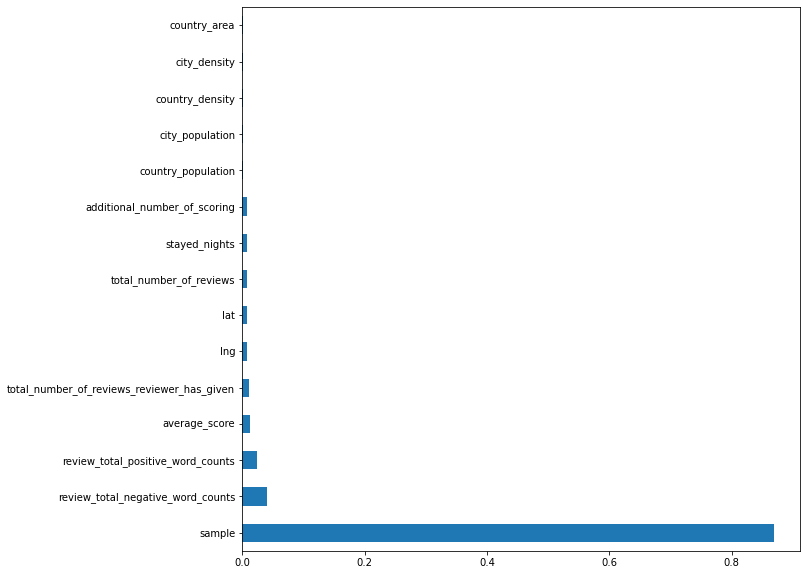

In [31]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [32]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,city_population,city_area,city_density,country_population,country_area,country_density,stayed_nights,reviewer_score,is_capital
120679,0.161507,0.695652,0.000000,0.087268,0.068354,0.127119,0.919737,0.004706,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,0.0,1
12469,0.362924,0.826087,0.007353,0.180249,0.369620,0.002825,0.918762,0.021026,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,0.0,1
109659,0.468855,0.913043,0.000000,0.250256,0.017722,0.016949,0.918916,0.021996,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,0.0,1
10137,0.015293,0.782609,0.107843,0.028327,0.103797,0.025424,0.681754,0.161501,0.157687,0.002732,1.000000,1.000000,1.000000,0.039039,0.033333,0.0,1
30620,0.977993,0.760870,0.046569,0.728634,0.022785,0.031073,0.918783,0.015070,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,0.0,1
31085,0.016785,0.608696,0.026961,0.023576,0.030380,0.000000,0.680370,0.158107,0.157687,0.002732,1.000000,1.000000,1.000000,0.039039,0.033333,0.0,1
82497,0.086908,0.608696,0.049020,0.075299,0.017722,0.014124,0.920000,0.012734,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,0.0,1
107586,0.013801,0.695652,0.017157,0.029169,0.022785,0.011299,0.681447,0.161520,0.157687,0.002732,1.000000,1.000000,1.000000,0.039039,0.033333,0.0,1
76413,0.370757,0.630435,0.000000,0.227522,0.040506,0.000000,0.919089,0.020020,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,0.0,1
79062,0.112272,0.652174,0.004902,0.051603,0.020253,0.002825,0.918824,0.012333,1.000000,1.000000,0.098568,0.983043,0.333664,0.552553,0.000000,0.0,1
